In [53]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [54]:
import os
folder = os.path.abspath(os.getcwd())

## Create network

In [55]:
case = "case14"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

In [56]:
net.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,3,0.0,True,6,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,2.2,135.0,14.000,2070.288,0.0
1,1.0,3,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,3.1,135.0,0.208,5506.182,0.0
2,1.0,4,0.0,True,5,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,6.8,135.0,0.208,2494.998,0.0
3,1.0,6,0.0,True,7,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,12.000,1743.885,0.0
4,1.0,6,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,0.208,1089.099,0.0


In [57]:
net.trafo["tap_step_percent"] = np.nan

In [59]:
# # deprecated
# net.bus["zone"] = None
# net.load = net.load.drop(["controllable"], axis=1)
# net.load["type"] = "wye"
# net.line.drop(["max_loading_percent"], axis=1)
# net.line["type"] = None
# net.f_hz = 50

# net.line["max_i_ka"] = np.zeros(len(net.line))
# net.line["c_nf_per_km"] = np.zeros(len(net.line))

In [60]:
# # convert all values to p.u.; no longer used

# # parameters
# net.load["p_mw"] = net.load["p_mw"] / net.sn_mva
# net.load["q_mvar"] = net.load["q_mvar"] / net.sn_mva

# net.line["r_ohm_per_km"] = np.array((net.line['r_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)
# net.line["x_ohm_per_km"] = np.array((net.line['x_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)

# # bounds
# for col_name in ["max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]:
#     net.gen[col_name] = net.gen[col_name] / net.sn_mva
#     net.ext_grid[col_name] = net.ext_grid[col_name] / net.sn_mva


# net.bus["vn_kv"] = 1
# net.sn_mva = 1

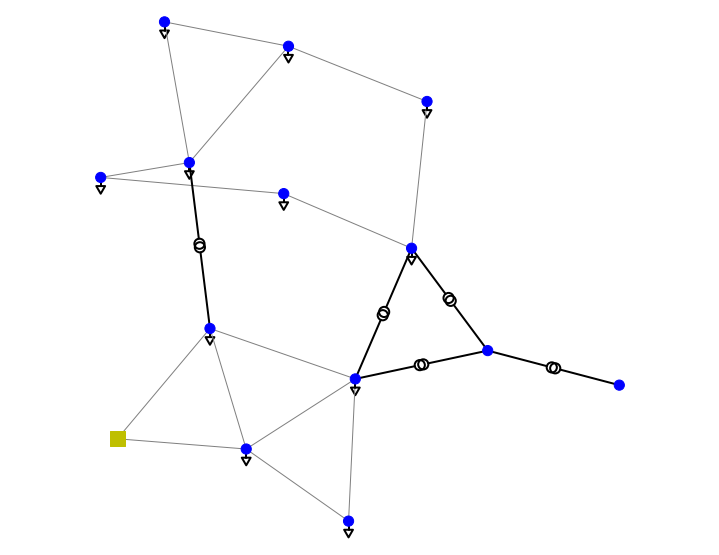

<AxesSubplot:>

In [61]:
simple_plot(net, plot_loads=True, plot_sgens=True)

## Solve

In [62]:
pp.runopp(net, verbose=False, suppress_warnings=False)

gen vm_pu > bus max_vm_pu for gens [2 3]. Setting bus limit for these gens.
/home/ivanightingale/anaconda3/envs/power/lib/python3.9/site-packages/pandapower/pypower/pipsopf_solver.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  Sf = V[ branch[:, F_BUS].astype(int) ] * conj(Yf * V)  ## cplx pwr at "from" bus, p["u"].
/home/ivanightingale/anaconda3/envs/power/lib/python3.9/site-packages/pandapower/pypower/pipsopf_solver.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  St = V[ branch[:, T_BUS].astype(int) ] * conj(Yt * V)  ## cplx pwr at "to" bus, p["u"].
/home/ivanightingale/anaconda3/envs/power/lib/python3.9/site-packages/pandapower/pypower/pipsopf_solver.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  muSf[il] = \
/home/ivanightingale/anaconda3/envs/power/lib/python3.9/site-packages/pandapower/pypower/pipsopf_solver.py:181: ComplexWarning: Casting complex values to real discard

In [63]:
net.res_cost

8079.95526588136

### Save solution

In [64]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")

In [65]:
V_polar = net.res_bus[["vm_pu", "va_degree"]].to_numpy()
V = V_polar[:,[0]] * np.exp(1j * (V_polar[:,[1]] / 180 * np.pi))
V

array([[1.06      +0.j        ],
       [1.0360069 -0.07204851j],
       [1.00049149-0.17440597j],
       [1.00863842-0.15553903j],
       [1.01605453-0.13458846j],
       [1.00447934-0.23386371j],
       [1.01260946-0.2063982j ],
       [1.04110631-0.19824474j],
       [0.9969015 -0.23824527j],
       [0.98959726-0.24104759j],
       [0.99301542-0.23914028j],
       [0.98633553-0.24574362j],
       [0.9819655 -0.24579464j],
       [0.96773491-0.25526852j]])

In [66]:
p_g = np.concatenate((net.res_ext_grid[["p_mw"]].to_numpy(), net.res_gen[["p_mw"]].to_numpy(), net.res_sgen[["p_mw"]].to_numpy())) \
    / net.sn_mva
q_g = np.concatenate((net.res_ext_grid[["q_mvar"]].to_numpy(), net.res_gen[["q_mvar"]].to_numpy(), net.res_sgen[["q_mvar"]].to_numpy())) \
    / net.sn_mva

In [67]:
p_g

array([[1.94477216e+00],
       [3.67478042e-01],
       [2.90077404e-01],
       [3.65617411e-06],
       [8.02609604e-02]])

In [68]:
# sfm.save_solution(net.res_cost, V, p_g, q_g)